In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

In [166]:
df = pd.read_csv("MC_Table_1.csv")

In [167]:
df.columns

Index(['Series No.', 'TI (ms)', 'ROI 1 (M1)', 'ROI 1 (S1)', 'ROI 1 (A1)',
       'ROI 2 (M2)', 'ROI 2 (S2)', 'ROI 2 (A2)', 'ROI 3 (M3)', 'ROI 3 (S3)',
       'ROI 3 (A3)', 'ROI 4 (M4)', 'ROI 4 (S4)', 'ROI 4 (A4)'],
      dtype='object')

In [168]:
df[["ROI 1 (M1)", "ROI 2 (M2)"]].describe()

,ROI 1 (M1),ROI 2 (M2)
count,10.000000,10.000000
mean,2465.735000,2169.306000
std,1049.843329,965.598599
min,423.970000,211.490000
25%,1765.167500,1945.060000
50%,2737.035000,2329.405000
75%,3274.795000,2979.360000
max,3457.110000,3065.260000


In [169]:
ROIs = ['ROI 1 (M1)', 'ROI 2 (M2)', 'ROI 3 (M3)', 'ROI 4 (M4)']

In [163]:
max_signal_intensity = df[ROIs].max().max()

In [164]:
# Normalize all ROIs
for roi in ROIs:
    df[roi] = df[roi] / max_signal_intensity

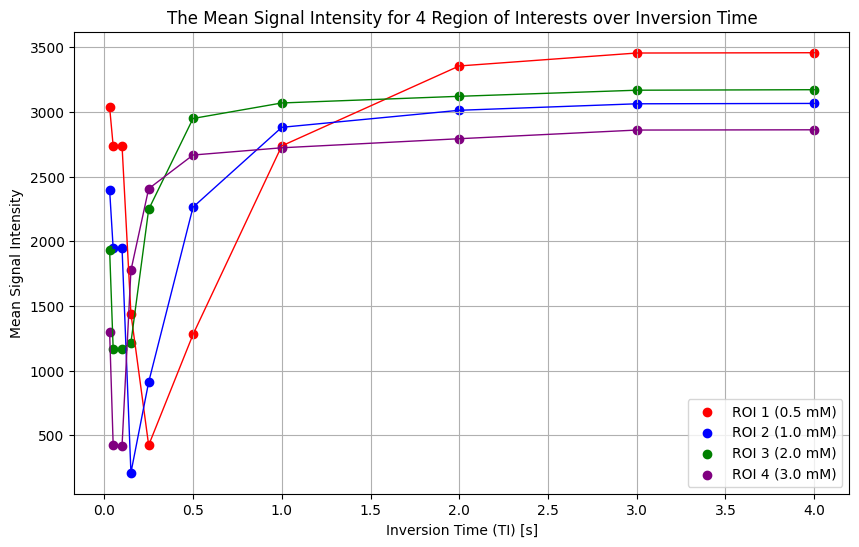

In [171]:
# Extract columns
TI = df['TI (ms)'] / 1000 # Time in seconds
ROI1 = df['ROI 1 (M1)']
ROI2 = df['ROI 2 (M2)']
ROI3 = df['ROI 3 (M3)']
ROI4 = df['ROI 4 (M4)']

# Plot each ROI
plt.figure(figsize=(10, 6))

# ROI 1
plt.scatter(TI, ROI1, label='ROI 1 (0.5 mM)', color='red')
plt.plot(TI, ROI1, color='red', linestyle='-', linewidth=1)

# ROI 2
plt.scatter(TI, ROI2, label='ROI 2 (1.0 mM)', color='blue')
plt.plot(TI, ROI2, color='blue', linestyle='-', linewidth=1)

# ROI 3
plt.scatter(TI, ROI3, label='ROI 3 (2.0 mM)', color='green')
plt.plot(TI, ROI3, color='green', linestyle='-', linewidth=1)

# ROI 4
plt.scatter(TI, ROI4, label='ROI 4 (3.0 mM)', color='purple')
plt.plot(TI, ROI4, color='purple', linestyle='-', linewidth=1)

# Add labels, legend, and title
plt.xlabel('Inversion Time (TI) [s]')
plt.ylabel('Mean Signal Intensity')
plt.title('The Mean Signal Intensity for 4 Region of Interests over Inversion Time')
plt.legend()
plt.grid(True)

plt.savefig('plots/signal_intensity_vs_TI.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve


# Model definition: I(TI) = A * (1 - B * exp(-TI / T1))
def model(params, TI):
    A, B, T1 = params
    return A * (1 - B * np.exp(-TI / T1))

# Jacobian matrix computation
def compute_jacobian(params, TI):
    A, B, T1 = params
    J = np.zeros((len(TI), len(params)))
    J[:, 0] = 1 - B * np.exp(-TI / T1)                    # dI/dA
    J[:, 1] = -A * np.exp(-TI / T1)                       # dI/dB
    J[:, 2] = A * B * (TI / T1**2) * np.exp(-TI / T1)     # dI/dT1
    return J

# Levenberg-Marquardt Algorithm
def levenberg_marquardt(TI, I, initial_guess, max_iter=100, tol=1e-6):
    params = np.array(initial_guess)
    lambda_damping = 0.01  # Initial damping factor

    for iteration in range(max_iter):
        # Compute model values and residuals
        I_model = model(params, TI)
        residuals = I - I_model

        # Compute Jacobian matrix
        J = compute_jacobian(params, TI)

        # Normal equations: (J^T * J + lambda * I) * delta = J^T * residuals
        H = J.T @ J + lambda_damping * np.eye(len(params))
        g = J.T @ residuals

        # Solve for parameter update
        delta = solve(H, g)

        # Test updated parameters
        params_new = params + delta

        # Ensure parameters remain positive
        params_new[0] = max(params_new[0], 0.01)  # A > 0
        params_new[1] = max(params_new[1], 0.01)  # B > 0
        params_new[2] = max(params_new[2], 0.01)  # T1 > 0

        # Evaluate new residuals
        I_model_new = model(params_new, TI)
        residuals_new = I - I_model_new

        # Check for improvement
        if np.sum(residuals_new**2) < np.sum(residuals**2):
            # Accept new parameters
            params = params_new
            lambda_damping /= 10
        else:
            # Increase damping factor
            lambda_damping *= 10

        # Check for convergence
        if np.linalg.norm(delta) < tol:
            print(f"Convergence reached after {iteration + 1} iterations.")
            break
    else:
        print("Maximum iterations reached without full convergence.")

    return params

def plot_non_linear_fit(TI, I, TI_fine, I_fit, ROI):
    plt.figure(figsize=(10, 6))
    plt.plot(TI, I, 'ro', label='Data')
    plt.plot(TI_fine, I_fit, 'b-', label='Fit')
    plt.xlabel('TI (s)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid()
    plt.title(f'Non-linear Fit of MR Intensity - {ROI}')
    plt.savefig(f"plots/Non-linear Fit of MR Intensity - {ROI}').png", dpi=300, bbox_inches='tight')
    plt.show()


def plot_concentration_vs_inverse_T1(concentrations, inverse_T1, ROIs):
    plt.figure(figsize=(10, 6))
    plt.plot(concentrations, inverse_T1, 'o-', label='Data')
    for i, roi in enumerate(ROIs):
        plt.text(concentrations[i], inverse_T1[i], roi, fontsize=9, ha='right')
    plt.xlabel('Concentration (mM)')
    plt.ylabel('1 / T1 (s^-1)')
    plt.title('Concentration of Dotarem vs. Inverse T1')
    plt.grid()
    plt.legend()
    plt.savefig(f"Concentration vs. Inverse T1').png", dpi=300, bbox_inches='tight')
    plt.show()



Convergence reached after 49 iterations.
ROI 1 (M1): Fitted Parameters: A = 0.9559, B = 0.4568, T1 = 0.9030


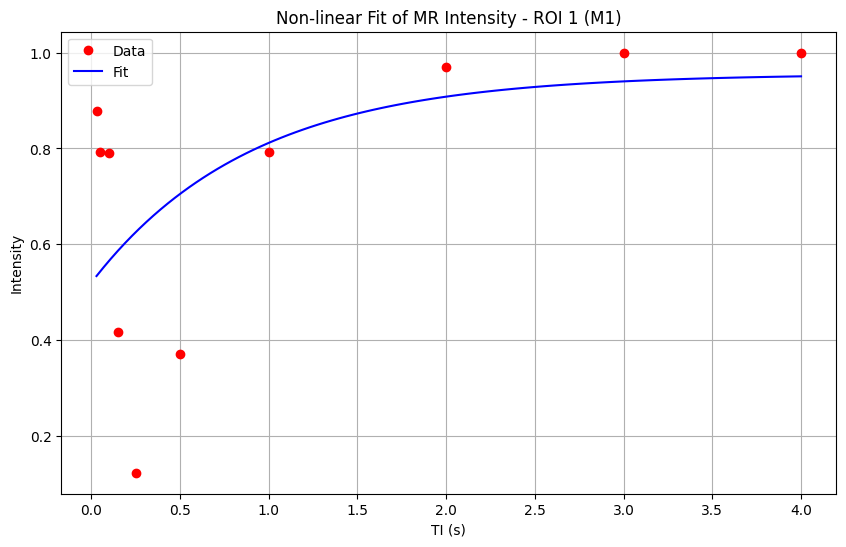

Convergence reached after 17 iterations.
ROI 2 (M2): Fitted Parameters: A = 0.7442, B = 0.5356, T1 = 0.2018


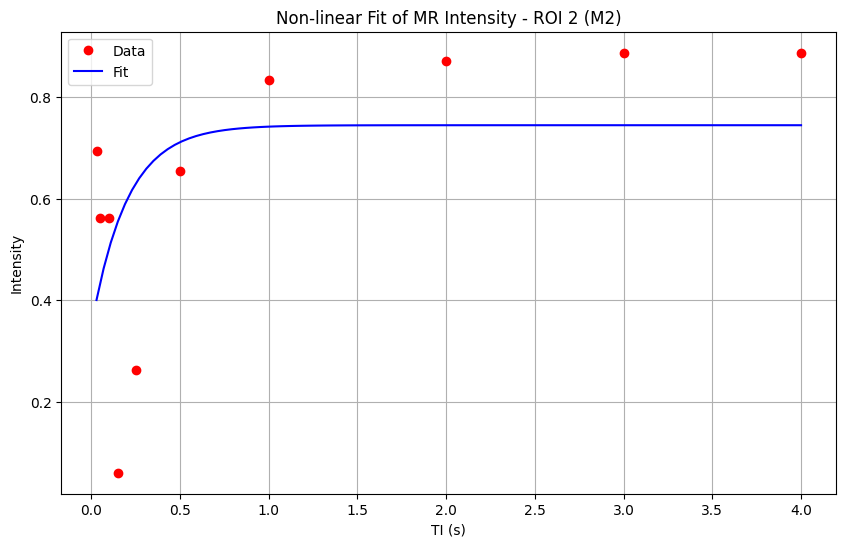

Convergence reached after 12 iterations.
ROI 3 (M3): Fitted Parameters: A = 0.8611, B = 0.8392, T1 = 0.1071


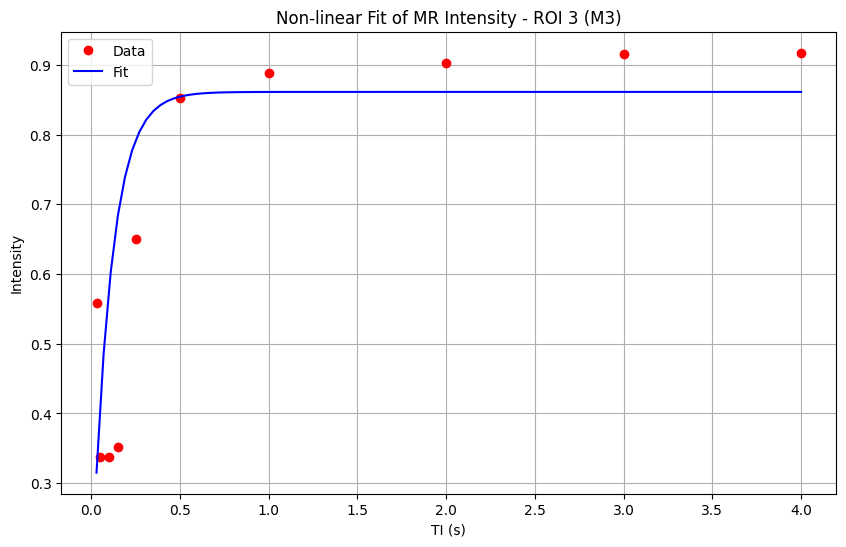

Convergence reached after 12 iterations.
ROI 4 (M4): Fitted Parameters: A = 0.7981, B = 0.9622, T1 = 0.1166


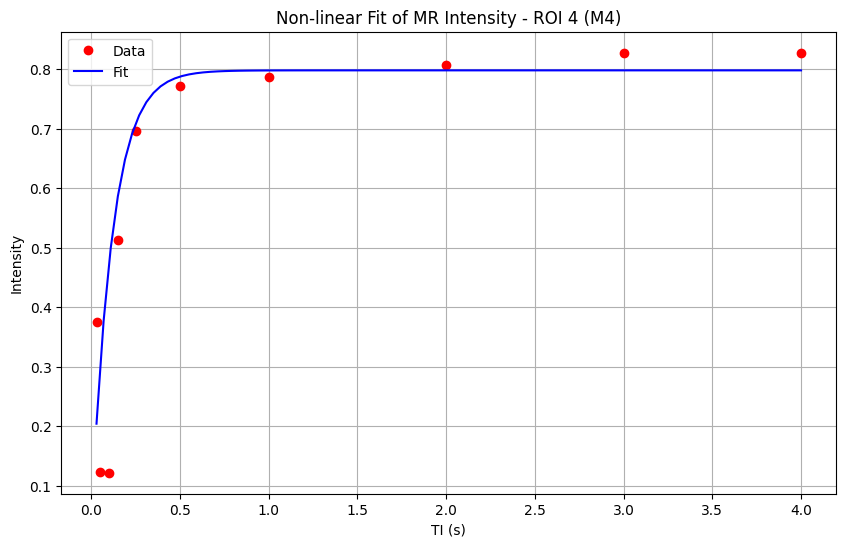

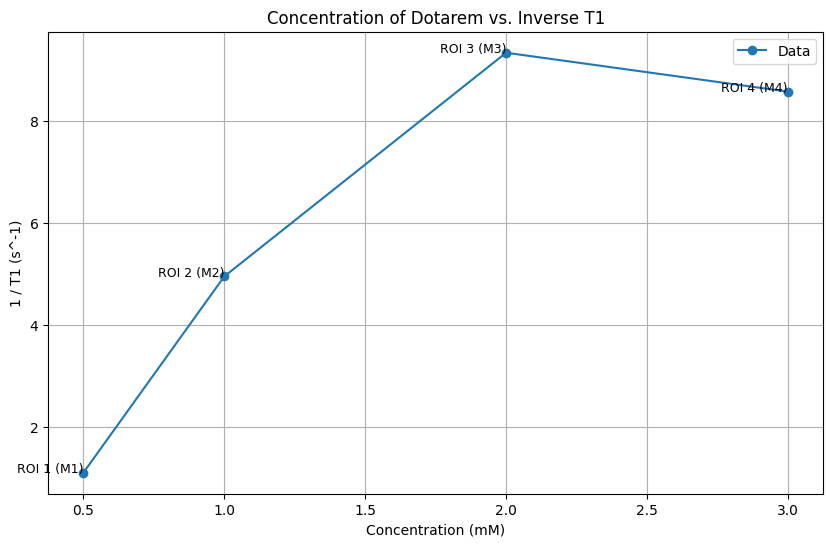

In [116]:
# Example data: Replace these with your own data
ROIs = ["ROI 1 (M1)", "ROI 2 (M2)", "ROI 3 (M3)", "ROI 4 (M4)"]
concentrations = [0.5, 1.0, 2.0, 3.0]  # Example concentrations in mM
inverse_T1 = []
for roi in ROIs:
    TI = np.array(df['TI (ms)'] / 1000)  # Time intervals (s)
    I = np.array(df[roi])

    # Initial guess for parameters: [A, B, T1]
    if roi in ['"ROI 1 (M1)", "ROI 2 (M2)"']:
        T1_initial = TI[np.argmin(np.abs(I - (0.63 * I.max())))] if len(I) > 2 else np.median(TI)
    else: 
        T1_initial = 0.15
    initial_guess = [0.7, 1, T1_initial]

    # Fit the data
    fitted_params = levenberg_marquardt(TI, I, initial_guess)
    A_fit, B_fit, T1_fit = fitted_params
    print(f"{roi}: Fitted Parameters: A = {A_fit:.4f}, B = {B_fit:.4f}, T1 = {T1_fit:.4f}")

    # Store the inverse T1
    inverse_T1.append(1 / T1_fit)

    # Plot results
    TI_fine = np.linspace(min(TI), max(TI), 100)
    I_fit = model(fitted_params, TI_fine)

    plot_non_linear_fit(TI, I, TI_fine, I_fit, roi)
plot_concentration_vs_inverse_T1(concentrations, inverse_T1, ROIs)

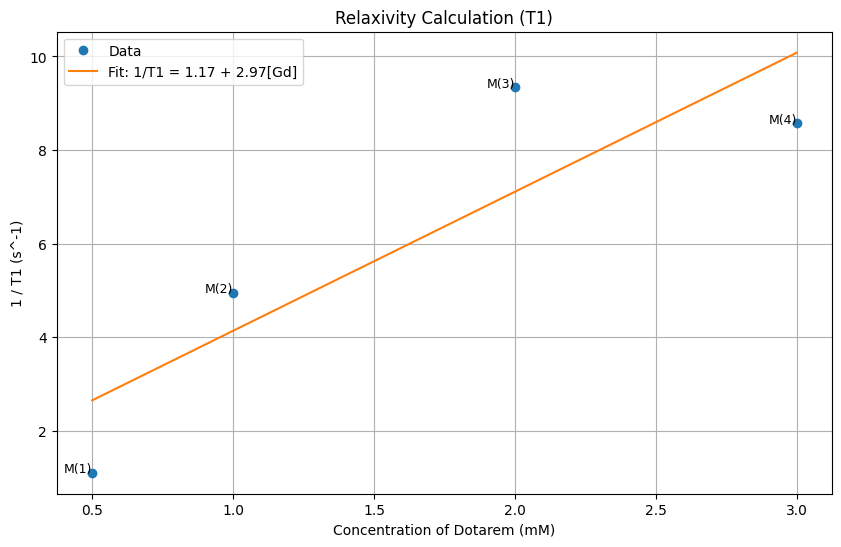

Relaxivity (r_t1): 2.9701 mM^-1 s^-1
1/T1^0 (Intercept): 1.1682 s^-1
R-squared: 0.7597


In [225]:
from scipy.stats import linregress

def calculate_and_plot_relaxivity(concentrations, inverse_relaxation, ROIs, relaxation_type="T1"):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(concentrations, inverse_relaxation)

    # Relaxivity (r) is the slope of the line
    relaxivity = slope
    offset = intercept  # 1 / T0 (y-intercept)

    # Generate linear fit values
    concentrations_fine = np.linspace(min(concentrations), max(concentrations), 100)
    fit_line = relaxivity * concentrations_fine + offset

    # Plot data and fit
    plt.figure(figsize=(10, 6))
    plt.plot(concentrations, inverse_relaxation, 'o', label='Data')
    plt.plot(concentrations_fine, fit_line, '-', label=f'Fit: 1/{relaxation_type} = {offset:.2f} + {relaxivity:.2f}[Gd]')
    for i, roi in enumerate(ROIs):
        plt.text(concentrations[i], inverse_relaxation[i], roi, fontsize=9, ha='right')
    plt.xlabel('Concentration of Dotarem (mM)')
    plt.ylabel(f'1 / {relaxation_type} (s^-1)')
    plt.title(f'Relaxivity Calculation ({relaxation_type})')
    plt.grid()
    plt.legend()
    plt.savefig(f"plots/Relaxivity_{relaxation_type}.png", dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Relaxivity (r_{relaxation_type.lower()}): {relaxivity:.4f} mM^-1 s^-1")
    print(f"1/{relaxation_type}^0 (Intercept): {offset:.4f} s^-1")
    print(f"R-squared: {r_value**2:.4f}")

# Call the function to calculate relaxivity
calculate_and_plot_relaxivity(concentrations, inverse_T1, ROIs)


In [197]:
df_t2 = pd.read_csv("t2_data.csv")

In [192]:
ROI1 = df_t2['M(1)']

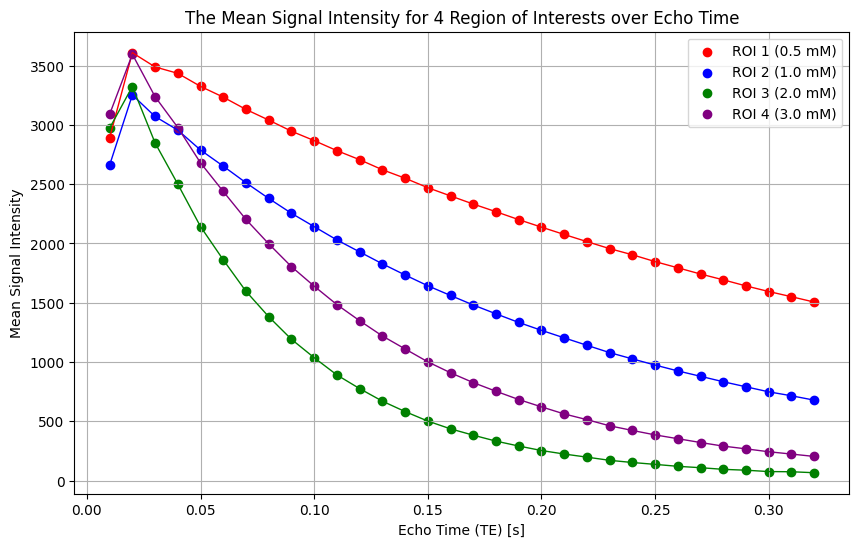

In [198]:
# Extract columns
TE = df_t2['TE'] / 1000 # Time in seconds
ROI1 = df_t2['M(1)']
ROI2 = df_t2['M(2)']
ROI3 = df_t2['M(3)']
ROI4 = df_t2['M(4)']

# Plot each ROI
plt.figure(figsize=(10, 6))

# ROI 1
plt.scatter(TE, ROI1, label='ROI 1 (0.5 mM)', color='red')
plt.plot(TE, ROI1, color='red', linestyle='-', linewidth=1)

# ROI 2
plt.scatter(TE, ROI2, label='ROI 2 (1.0 mM)', color='blue')
plt.plot(TE, ROI2, color='blue', linestyle='-', linewidth=1)

# ROI 3
plt.scatter(TE, ROI3, label='ROI 3 (2.0 mM)', color='green')
plt.plot(TE, ROI3, color='green', linestyle='-', linewidth=1)

# ROI 4
plt.scatter(TE, ROI4, label='ROI 4 (3.0 mM)', color='purple')
plt.plot(TE, ROI4, color='purple', linestyle='-', linewidth=1)

# Add labels, legend, and title
plt.xlabel('Echo Time (TE) [s]')
plt.ylabel('Mean Signal Intensity')
plt.title('The Mean Signal Intensity for 4 Region of Interests over Echo Time')
plt.legend()
plt.grid(True)

plt.savefig('signal_intensity_vs_TE.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [199]:
ROIs = ['M(1)', 'M(2)', 'M(3)', 'M(4)']

In [200]:
max_signal_intensity = df_t2[ROIs].max().max()
max_signal_intensity

3609.26

In [201]:
# Normalize all ROIs
for roi in ROIs:
    df_t2[roi] = df_t2[roi] / max_signal_intensity

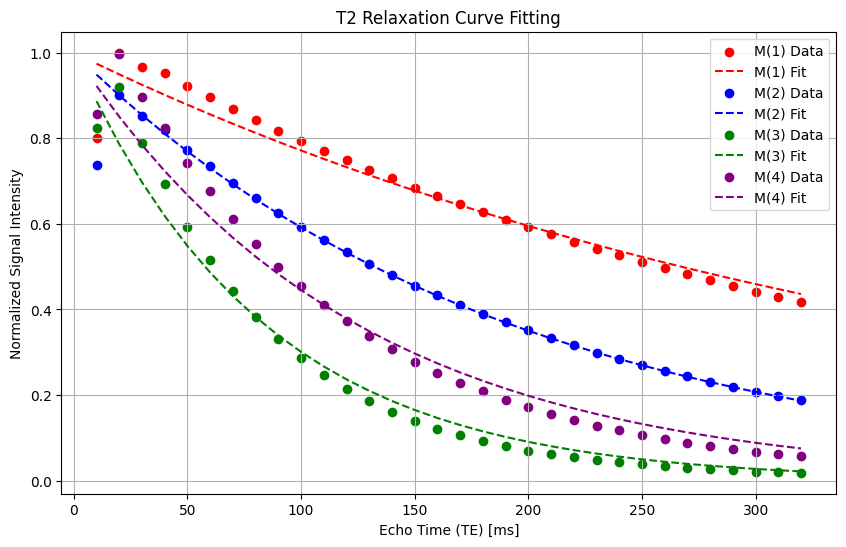


Fitted Parameters:
M(1): A = 1.00 (Normalized), T2 = 385.55 ± 9.86 ms
M(2): A = 1.00 (Normalized), T2 = 190.64 ± 4.08 ms
M(3): A = 1.00 (Normalized), T2 = 83.23 ± 2.25 ms
M(4): A = 1.00 (Normalized), T2 = 123.58 ± 3.57 ms


In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

T2_list = []

# Define the T2 relaxation model
def t2_relaxation(TE, T2):
    return np.exp(-TE / T2)

# Extract TI and ROIs
TE = df_t2['TE']

roi_colors = {
    "M(1)": "red",
    "M(2)": "blue",
    "M(3)": "green",
    "M(4)": "purple"
}

inverse_T2 = list()

# Fit and plot for each ROI
fitted_params = {}
plt.figure(figsize=(10, 6))

for roi in ROIs:
    signal = df_t2[roi]

    T2_initial = 100
    
    T2_lower = 0.5 * T2_initial

    T2_upper = 5 * T2_initial  


    try:
        # Fit the normalized data with error handling and weighting
        popt, pcov = curve_fit(
            t2_relaxation,
            TE,
            signal,
            p0=(T2_initial),
            bounds=([T2_lower], [T2_upper])  # Adjust bounds for T2
        )
        T2 = popt[0]
        T2_err = np.sqrt(np.diag(pcov))[0]  # Standard deviation of T2
        T2_list.append(T2)

        T2_seconds = T2 / 1000
        inverse_T2.append(1 / T2_seconds)

        # Store fitted parameters
        fitted_params[roi] = {"A": 1, "T2": T2, "T2_err": T2_err}

        # Get color for the current ROI
        color = roi_colors.get(roi, "black")  
        
        # Plot the data and the fitted curve
        plt.scatter(TE, signal, label=f'{roi} Data', marker='o', color=color)
        plt.plot(TE, t2_relaxation(TE, T2), label=f'{roi} Fit', linestyle='--', color=color)

    except RuntimeError:
        print(f"Fit failed for {roi}")
        fitted_params[roi] = {"A": None, "T2": None}
        continue

# Add labels, title, and legend
plt.xlabel('Echo Time (TE) [ms]')
plt.ylabel('Normalized Signal Intensity')
plt.title('T2 Relaxation Curve Fitting')
plt.legend()
plt.grid(True)
plt.savefig('plots/T2 Relaxation Curve Fitting.png', dpi=300, bbox_inches='tight')
plt.show()

# Display fitted parameters with uncertainties
print("\nFitted Parameters:")
for roi, params in fitted_params.items():
    if params["T2"] is not None:
        print(f"{roi}: A = {params['A']:.2f} (Normalized), T2 = {params['T2']:.2f} ± {params['T2_err']:.2f} ms")
    else:
        print(f"{roi}: Fit failed.")



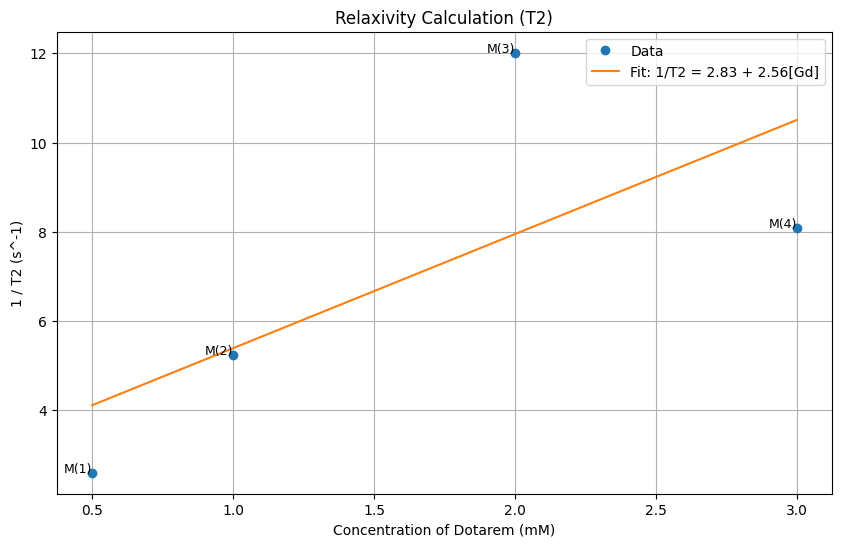

Relaxivity (r_t2): 2.5587 mM^-1 s^-1
1/T2^0 (Intercept): 2.8283 s^-1
R-squared: 0.4944


In [226]:
calculate_and_plot_relaxivity(concentrations, inverse_T2, ROIs, "T2")

In [227]:
df_seq_se = pd.read_csv("seq_se.csv")
df_seq_se

,TE,M(1),M(2),M(3),M(4)
0,15,2914.62,2935.36,2831.83,2649.55
1,30,2800.65,2456.13,2533.00,2298.76
2,60,2569.02,2092.73,1876.29,1460.30
3,120,2163.24,1523.49,1033.67,607.43
4,240,1289.32,605.63,201.01,122.18
5,300,1521.61,804.71,324.91,142.47


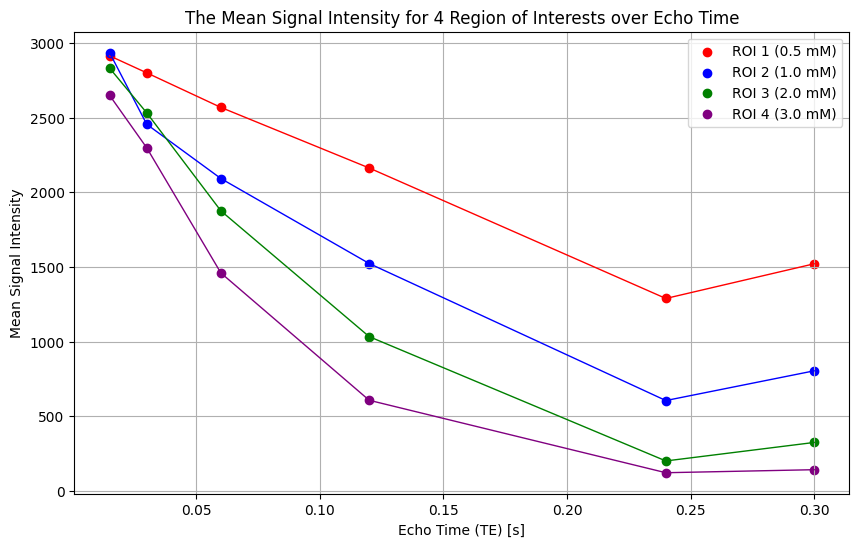

In [230]:
# Extract columns
TE = df_seq_se['TE'] / 1000 # Time in seconds
ROI1 = df_seq_se['M(1)']
ROI2 = df_seq_se['M(2)']
ROI3 = df_seq_se['M(3)']
ROI4 = df_seq_se['M(4)']

# Plot each ROI
plt.figure(figsize=(10, 6))

# ROI 1
plt.scatter(TE, ROI1, label='ROI 1 (0.5 mM)', color='red')
plt.plot(TE, ROI1, color='red', linestyle='-', linewidth=1)

# ROI 2
plt.scatter(TE, ROI2, label='ROI 2 (1.0 mM)', color='blue')
plt.plot(TE, ROI2, color='blue', linestyle='-', linewidth=1)

# ROI 3
plt.scatter(TE, ROI3, label='ROI 3 (2.0 mM)', color='green')
plt.plot(TE, ROI3, color='green', linestyle='-', linewidth=1)

# ROI 4
plt.scatter(TE, ROI4, label='ROI 4 (3.0 mM)', color='purple')
plt.plot(TE, ROI4, color='purple', linestyle='-', linewidth=1)

# Add labels, legend, and title
plt.xlabel('Echo Time (TE) [s]')
plt.ylabel('Mean Signal Intensity')
plt.title('The Mean Signal Intensity for 4 Region of Interests over Echo Time')
plt.legend()
plt.grid(True)

plt.savefig('plots/2nd_seq_signal_intensity_vs_TE.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [232]:
# Normalize all ROIs
max_signal_intensity = df_seq_se[ROIs].max().max()
max_signal_intensity
for roi in ROIs:
    df_seq_se[roi] = df_seq_se[roi] / max_signal_intensity

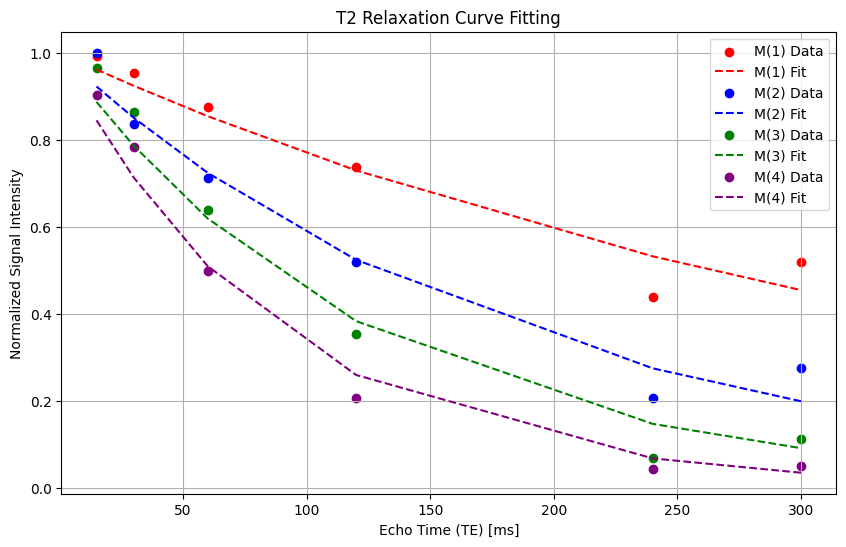


Fitted Parameters:
M(1): A = 1.00 (Normalized), T2 = 380.02 ± 36.97 ms
M(2): A = 1.00 (Normalized), T2 = 185.50 ± 16.49 ms
M(3): A = 1.00 (Normalized), T2 = 124.94 ± 12.46 ms
M(4): A = 1.00 (Normalized), T2 = 88.82 ± 7.18 ms


In [234]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

T2_list = []

# Define the T2 relaxation model
def t2_relaxation(TE, T2):
    return np.exp(-TE / T2)

# Extract TI and ROIs
TE = df_seq_se['TE']

roi_colors = {
    "M(1)": "red",
    "M(2)": "blue",
    "M(3)": "green",
    "M(4)": "purple"
}

inverse_T2 = list()

# Fit and plot for each ROI
fitted_params = {}
plt.figure(figsize=(10, 6))

for roi in ROIs:
    signal = df_seq_se[roi]

    T2_initial = 100
    
    T2_lower = 0.5 * T2_initial

    T2_upper = 5 * T2_initial  


    try:
        # Fit the normalized data with error handling and weighting
        popt, pcov = curve_fit(
            t2_relaxation,
            TE,
            signal,
            p0=(T2_initial),
            bounds=([T2_lower], [T2_upper])  # Adjust bounds for T2
        )
        T2 = popt[0]
        T2_err = np.sqrt(np.diag(pcov))[0]  # Standard deviation of T2
        T2_list.append(T2)

        T2_seconds = T2 / 1000
        inverse_T2.append(1 / T2_seconds)

        # Store fitted parameters
        fitted_params[roi] = {"A": 1, "T2": T2, "T2_err": T2_err}

        # Get color for the current ROI
        color = roi_colors.get(roi, "black")  
        
        # Plot the data and the fitted curve
        plt.scatter(TE, signal, label=f'{roi} Data', marker='o', color=color)
        plt.plot(TE, t2_relaxation(TE, T2), label=f'{roi} Fit', linestyle='--', color=color)

    except RuntimeError:
        print(f"Fit failed for {roi}")
        fitted_params[roi] = {"A": None, "T2": None}
        continue

# Add labels, title, and legend
plt.xlabel('Echo Time (TE) [ms]')
plt.ylabel('Normalized Signal Intensity')
plt.title('T2 Relaxation Curve Fitting')
plt.legend()
plt.grid(True)
plt.savefig('plots/2nd_seq T2 Relaxation Curve Fitting.png', dpi=300, bbox_inches='tight')
plt.show()

# Display fitted parameters with uncertainties
print("\nFitted Parameters:")
for roi, params in fitted_params.items():
    if params["T2"] is not None:
        print(f"{roi}: A = {params['A']:.2f} (Normalized), T2 = {params['T2']:.2f} ± {params['T2_err']:.2f} ms")
    else:
        print(f"{roi}: Fit failed.")



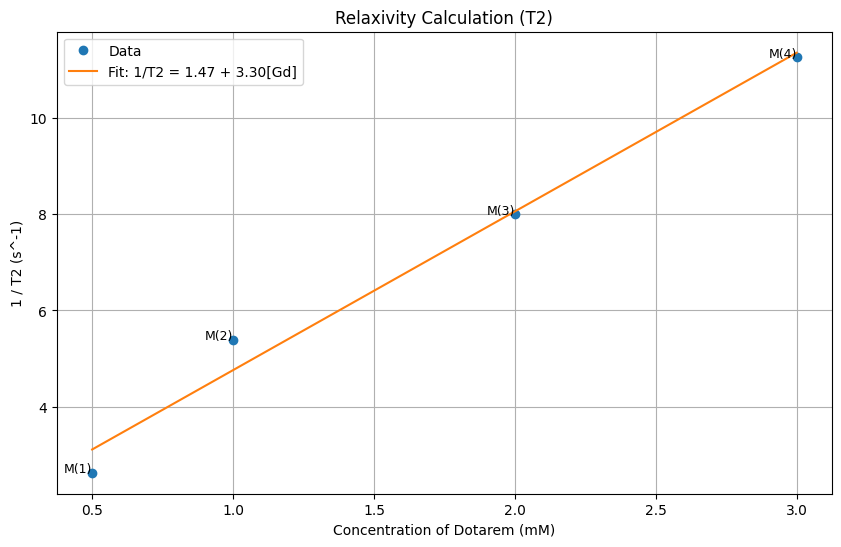

Relaxivity (r_t2): 3.2955 mM^-1 s^-1
1/T2^0 (Intercept): 1.4660 s^-1
R-squared: 0.9843


In [235]:
calculate_and_plot_relaxivity(concentrations, inverse_T2, ROIs, "T2")